In [14]:
import h5py as h5
import vector
import numpy as np
import matplotlib.pyplot as plt


In [15]:
def select_bjets(jets):
    jets = jets[jets['is_tagged']]
    # FIXME: you need to implement assignment of b tagged jets to bottom and anti-bottom quarks
    jets = np.take_along_axis(
        arr=jets,
        indices=np.argsort(jets['pt'])[::-1], 
        axis=0,
    )
    assert len(jets) >= 2
    return jets[:2]

def to_p4(arr):
    return vector.MomentumNumpy4D({
        key: arr[key]
        for key in ['pt', 'eta', 'phi', 'energy']
    })

In [16]:
# test set
path = '/home/sjlee/nu2flows/data/test.h5'

# output file created by export.py
nu_path = '../logs/nu2flows/test/outputs/test.h5'

In [17]:
with h5.File(path) as file:
    group = file['delphes']

    # NB use events with at least two b-tagged jets
    nbjets_mask = group['nbjets'][:] >= 2

    jet_arr = group['jets'][:][nbjets_mask]
    lepton_arr = group['leptons'][:][nbjets_mask]

In [18]:
bjet_arr = [select_bjets(each) for each in jet_arr]
bjet_arr = np.stack(bjet_arr)
# FIXME: you need to implement assignment of b tagged jets to bottom and anti-bottom quarks
b_arr = bjet_arr[:, 0]
print(b_arr)
anti_b_arr = bjet_arr[:, 1]
print(anti_b_arr)
b_arr = to_p4(bjet_arr[:, 0])
anti_b_arr = to_p4(anti_b_arr)

[( 96.315   ,  1.9285078 ,  2.1703353, 338.37473 ,  True)
 ( 82.26737 ,  1.6926122 , -2.1545324, 231.31833 ,  True)
 (161.94249 , -0.37984452, -1.724865 , 173.94228 ,  True) ...
 ( 79.5894  ,  0.5606798 ,  1.4709672,  92.97291 ,  True)
 (115.57845 ,  0.31823125,  1.0633607, 123.115486,  True)
 ( 49.931934,  0.80052024, -3.1176598,  67.23537 ,  True)]
[( 49.08103 ,  0.33861488, -2.6214592 ,  52.205303,  True)
 ( 67.60027 ,  0.64369774,  0.76236457,  82.64703 ,  True)
 (149.5571  , -1.0444698 ,  1.5865017 , 239.12695 ,  True) ...
 ( 45.41257 ,  0.2421015 , -0.32276845,  46.97098 ,  True)
 ( 49.270496,  2.0969765 ,  2.1623037 , 203.88634 ,  True)
 ( 45.949997, -0.9803146 ,  1.6940682 ,  70.06358 ,  True)]


In [19]:
lepton_arr = np.take_along_axis(
    arr=lepton_arr, 
    indices=np.argsort(lepton_arr['charge'], axis=1), 
    axis=1,
)
lep_neg_arr, lep_pos_arr = lepton_arr.T

In [20]:
lep_neg_arr = to_p4(lep_neg_arr)
lep_pos_arr = to_p4(lep_pos_arr)

In [21]:
with h5.File(nu_path) as file:
    anti_nu_arr = file['antineutrino'][:][nbjets_mask]
    nu_arr = file['neutrino'][:][nbjets_mask]

nu_arr = vector.MomentumNumpy4D(dict(
    px=nu_arr[:, 0],
    py=nu_arr[:, 1],
    pz=nu_arr[:, 2],
    mass=np.zeros_like(nu_arr[:, 0])
))

anti_nu_arr = vector.MomentumNumpy4D(dict(
    px=anti_nu_arr[:, 0],
    py=anti_nu_arr[:, 1],
    pz=anti_nu_arr[:, 2],
    mass=np.zeros_like(anti_nu_arr[:, 0])
))

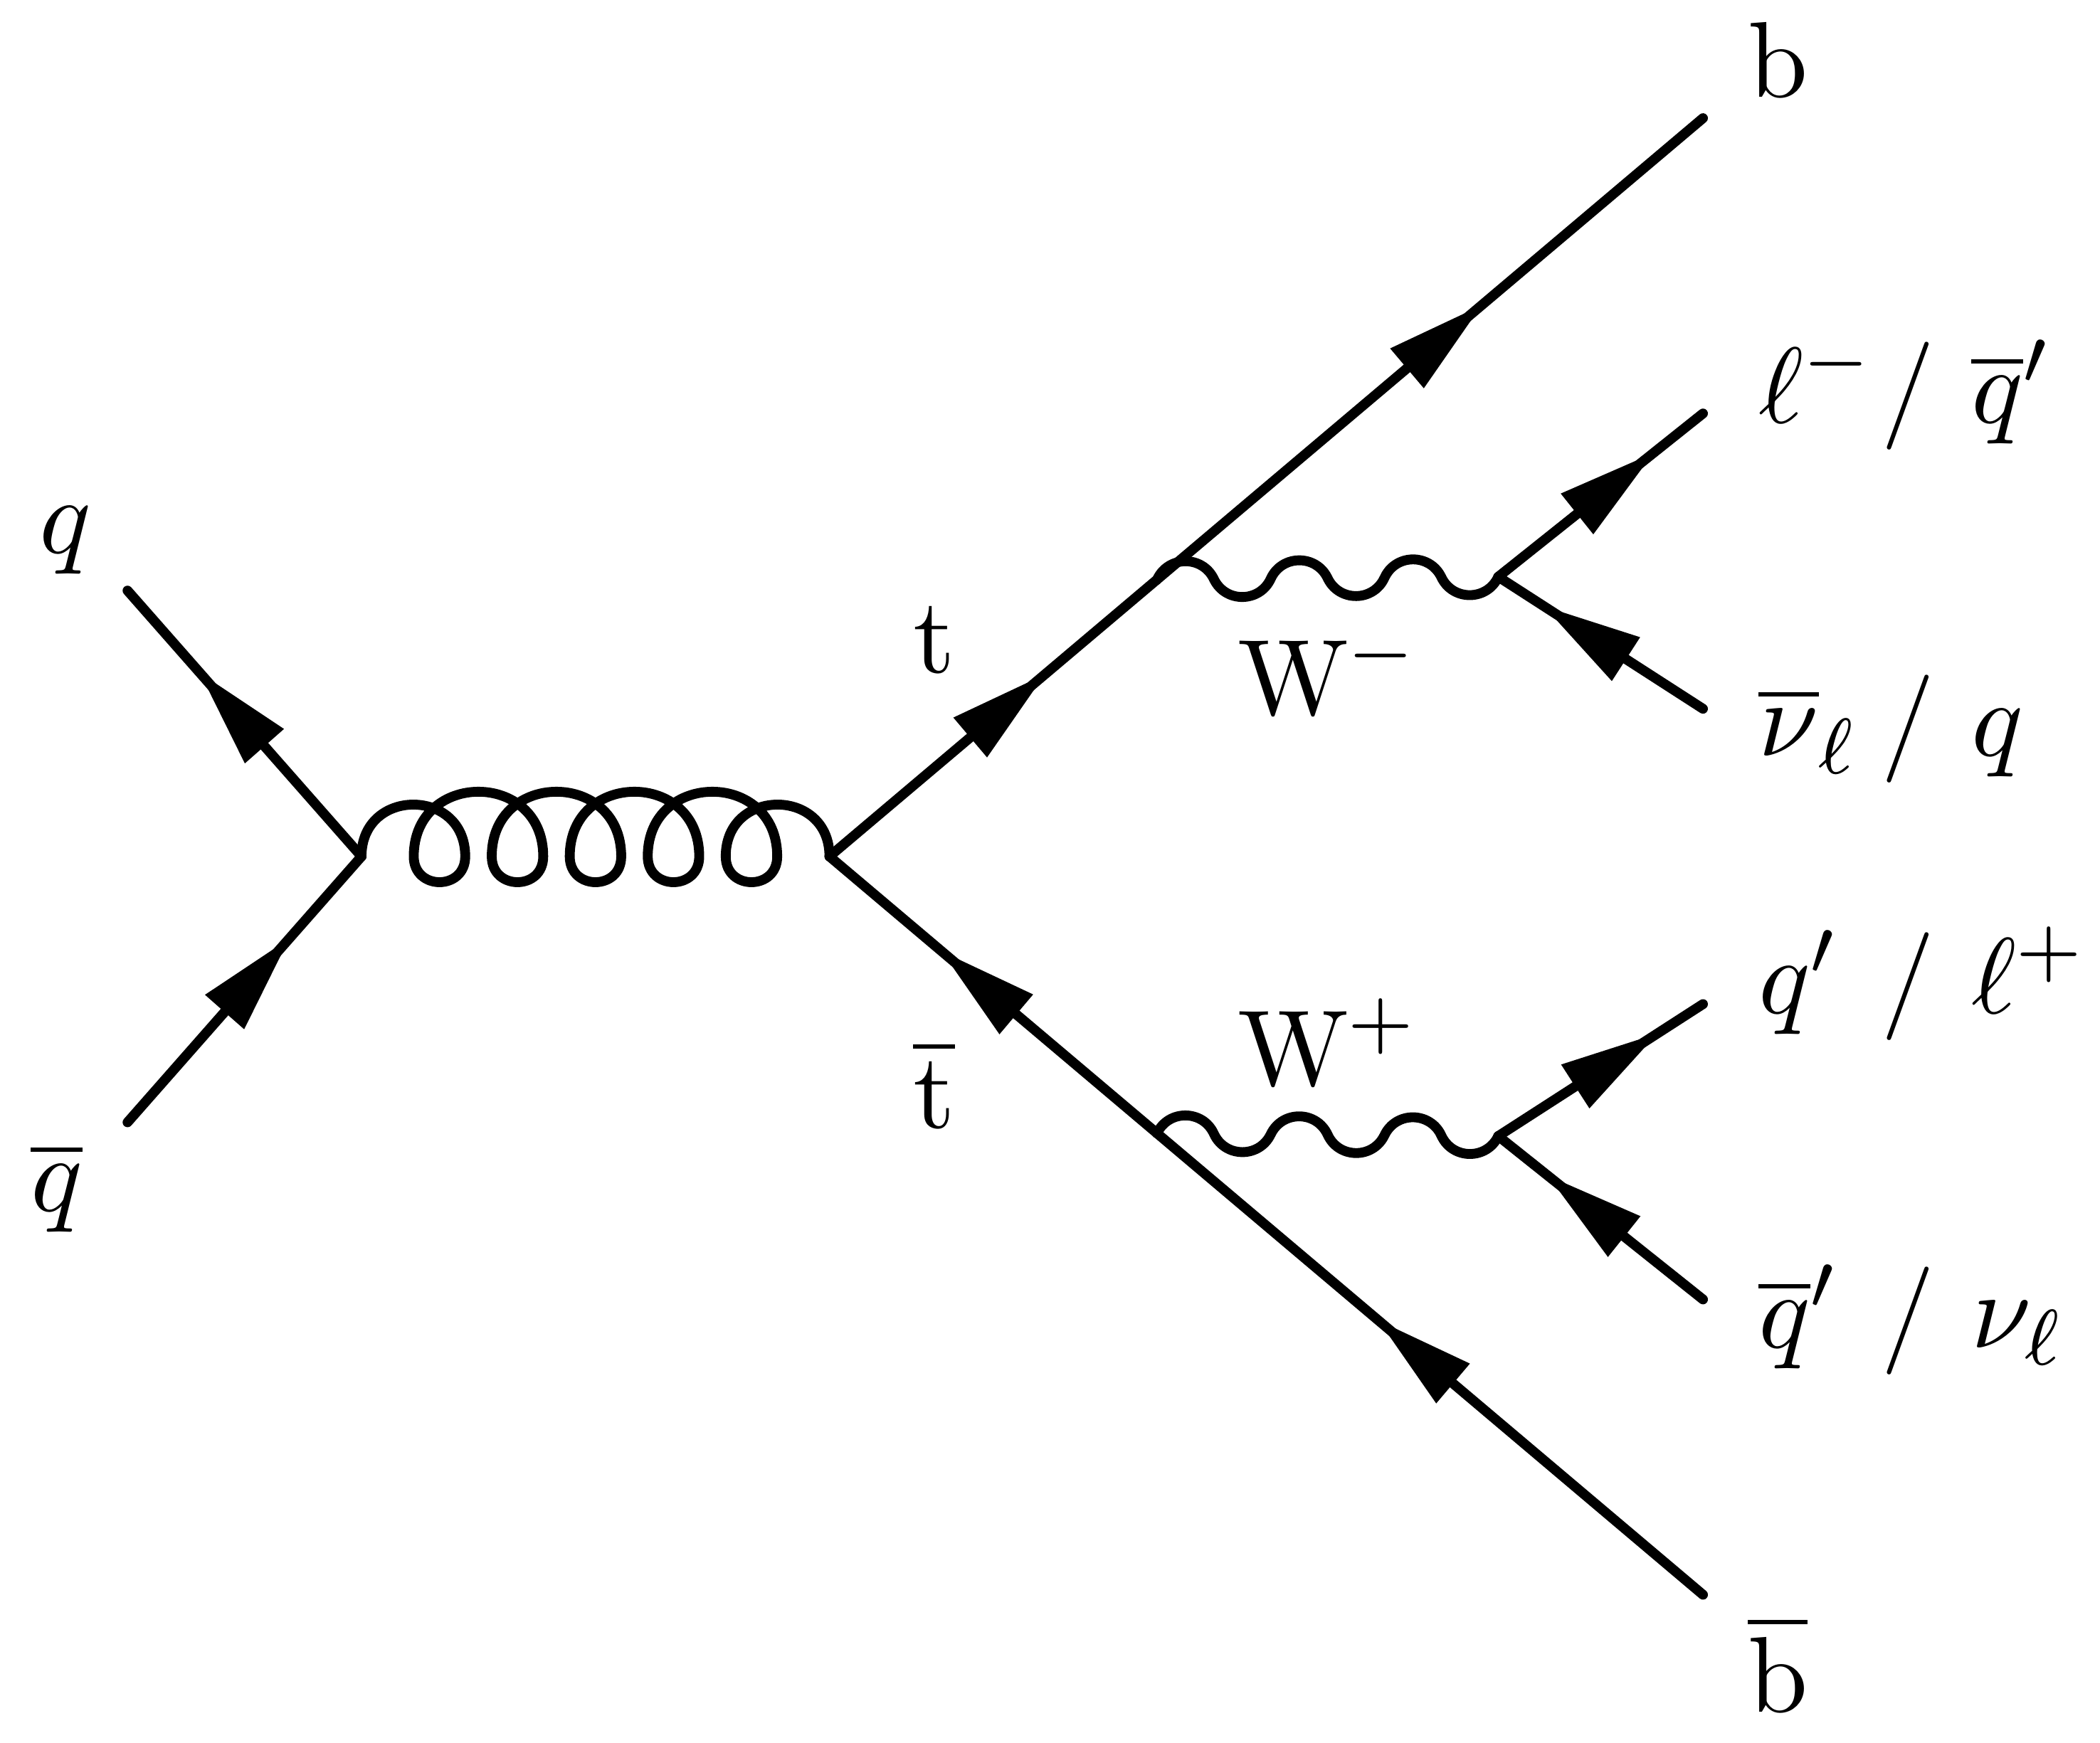

In [29]:
from IPython.display import Image
Image("ttbar-008.png", width=400, height=300)


In [23]:
w_neg_arr = lep_neg_arr + anti_nu_arr
w_pos_arr = lep_pos_arr + nu_arr


In [24]:
t_arr = b_arr + w_neg_arr
anti_t_arr = anti_b_arr + w_pos_arr

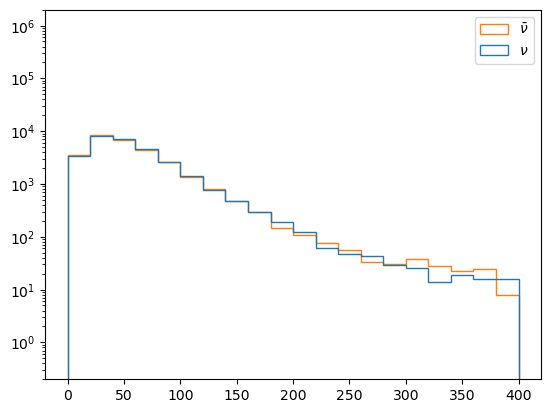

In [25]:
fig, ax = plt.subplots()
_ = ax.hist(
    [nu_arr.pt, anti_nu_arr.pt], 
    label=[r'$\nu$', r'$\bar{\nu}$'], 
    range=(0, 400), 
    bins=20, 
    histtype='step',
)
ax.set_yscale('log')
ax.set_ylim(0.2, 2e6) 
ax.legend()

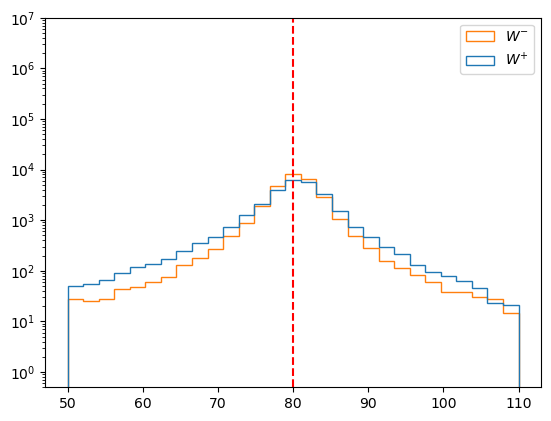

In [26]:
fig, ax = plt.subplots()

_ = ax.hist(
    [w_pos_arr.mass, w_neg_arr.mass], 
    label=[r'$W^{+}$', r'$W^{-}$'],
    range=(50, 110), 
    bins=29, 
    histtype='step',
)

ax.axvline(80, color='red', ls='--')
ax.set_yscale('log')
ax.set_ylim(5e-1, 1e7)
ax.legend()

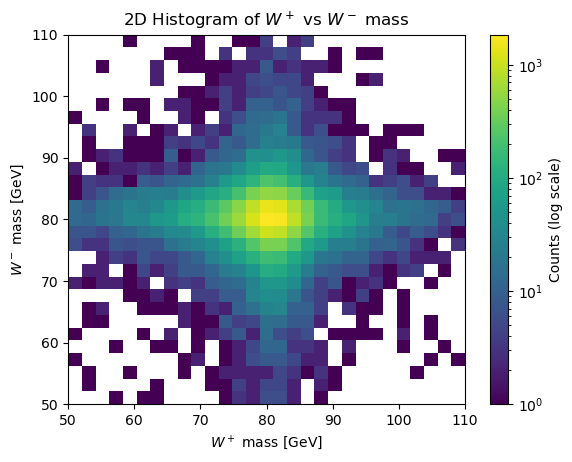

In [27]:
import matplotlib.pyplot as plt
import matplotlib as mpl  # 이렇게 해야 mpl.colors.LogNorm 사용 가능



fig, ax = plt.subplots()

h = ax.hist2d(
    w_pos_arr.mass,
    w_neg_arr.mass,
    bins=(29, 29),
    range=((50, 110), (50, 110)),
    cmap='viridis',
    norm=mpl.colors.LogNorm()
)

ax.set_xlabel(r'$W^+$ mass [GeV]')
ax.set_ylabel(r'$W^-$ mass [GeV]')
ax.set_title("2D Histogram of $W^+$ vs $W^-$ mass")
fig.colorbar(h[3], ax=ax, label="Counts (log scale)")


Text(0.5, 1.0, 'm(t) looks wrong because our assignment strategy is dumb!!!')

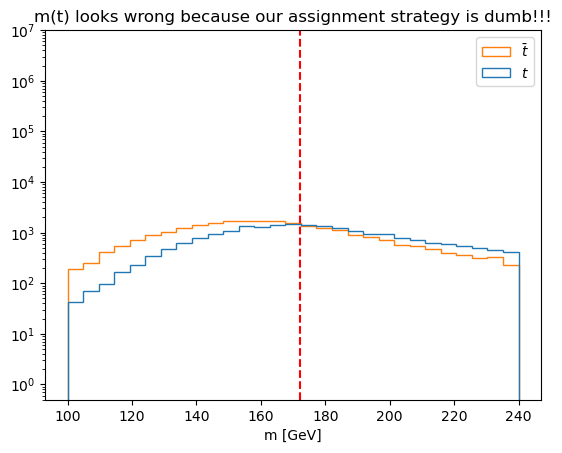

In [28]:
fig, ax = plt.subplots()

_ = ax.hist(
    [t_arr.mass, anti_t_arr.mass], 
    label=[r'$t$', r'$\bar{t}$'],
    range=(100, 240), 
    bins=29, 
    histtype='step',
)

ax.axvline(172, color='red', ls='--')
ax.set_yscale('log')
ax.set_ylim(5e-1, 1e7)
ax.legend()
ax.set_xlabel(r'm [GeV]')
ax.set_title('m(t) looks wrong because our assignment strategy is dumb!!!')

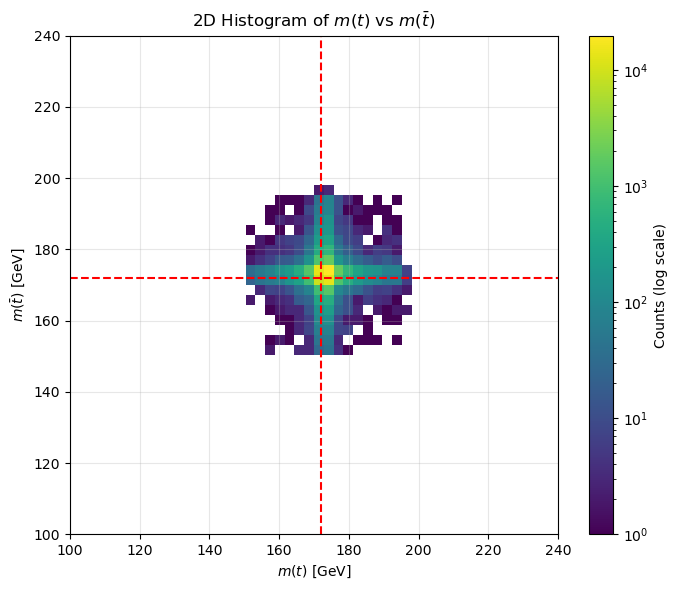

In [31]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# 파일 열기
with h5py.File(path, "r") as f:
    truth_particles = f["delphes/truth_particles"][:]

# numpy structured array에서 PDGID 필드 기준으로 분리
t_mask = truth_particles["PDGID"] == 6
anti_t_mask = truth_particles["PDGID"] == -6

t_arr = truth_particles[t_mask]
anti_t_arr = truth_particles[anti_t_mask]

# Top, Anti-top 질량이 일대일로 존재한다고 가정 (index 정렬 상태도 가정)
min_len = min(len(t_arr), len(anti_t_arr))
top_mass = t_arr["mass"][:min_len]
antitop_mass = anti_t_arr["mass"][:min_len]

# 2D Histogram 그리기
plt.figure(figsize=(7, 6))
plt.hist2d(
    top_mass,
    antitop_mass,
    bins=50,
    range=[[100, 240], [100, 240]],
    cmap="viridis",
    norm="log"
)
plt.xlabel(r"$m(t)$ [GeV]")
plt.ylabel(r"$m(\bar{t})$ [GeV]")
plt.colorbar(label="Counts (log scale)")
plt.title("2D Histogram of $m(t)$ vs $m(\\bar{t})$")
plt.axvline(172, color='red', linestyle='--')
plt.axhline(172, color='red', linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


true =  75496
reco =  29485


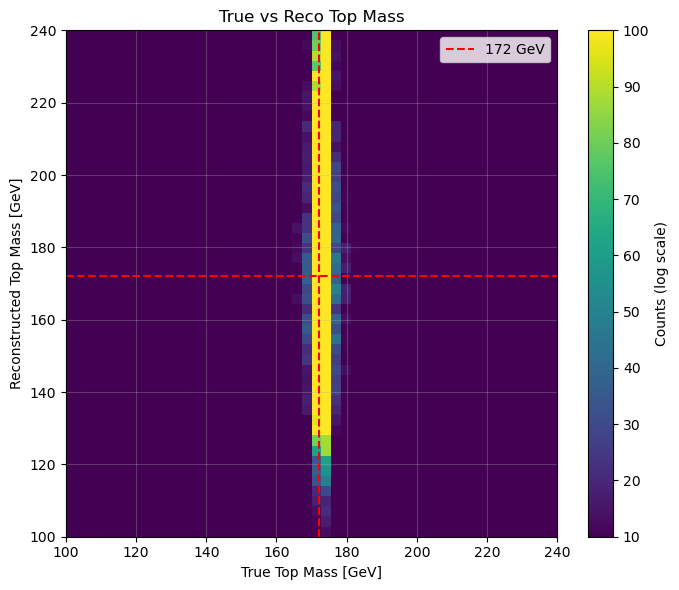

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import vector

# b_arr, w_neg_arr는 vector 배열이라고 가정
with h5py.File(path, "r") as f:
    truth_particles = f["delphes/truth_particles"][:]
top_mask = (truth_particles["PDGID"] == 6)
top_quarks = truth_particles[top_mask]
true_mass = top_quarks["mass"]  # 여기 수정됨!

# t_arr은 h5py에서 불러온 structured array라고 가정
t_arr = b_arr + w_neg_arr
reco_mass = t_arr.mass
print("true = ",len(true_mass))
print("reco = ",len(reco_mass))
# 길이 맞추기
min_len = min(len(true_mass), len(reco_mass))
true_mass = true_mass[:min_len]
reco_mass = reco_mass[:min_len]

# 2D Histogram
plt.figure(figsize=(7, 6))
plt.hist2d(
    true_mass,
    reco_mass,
    bins=50,
    range=[[100, 240], [100, 240]],
    cmap="viridis",
    vmin=10, vmax=100  # 적절히 조정 
    #norm="log"
)
plt.xlabel("True Top Mass [GeV]")
plt.ylabel("Reconstructed Top Mass [GeV]")
plt.colorbar(label="Counts (log scale)")
plt.axvline(172, color='red', linestyle='--', label="172 GeV")
plt.axhline(172, color='red', linestyle='--')
plt.legend()
plt.title("True vs Reco Top Mass")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


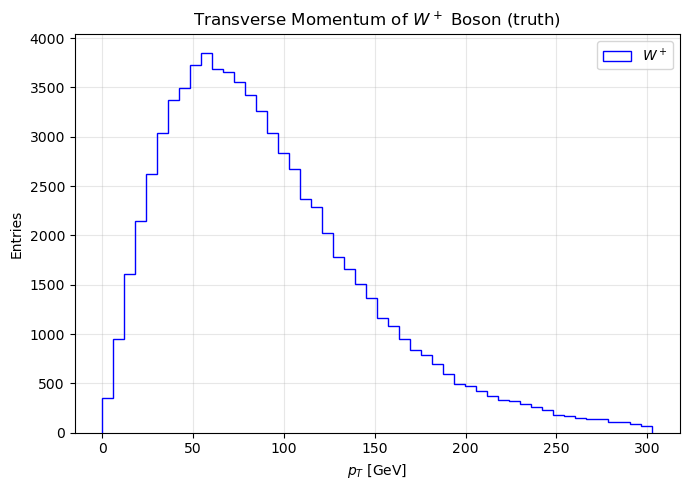

In [50]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# 파일 열기
with h5py.File(path, "r") as f:
    truth_particles = f["delphes/truth_particles"][:]

# W⁺ boson만 선택 (PDGID = +24)
w_pos_mask = truth_particles["PDGID"] == 24
w_pos_arr = truth_particles[w_pos_mask]

# pt 추출
w_pt = w_pos_arr["pt"]

# 히스토그램 그리기
plt.figure(figsize=(7, 5))
plt.hist(w_pt, bins=50, range=(0, np.percentile(w_pt, 99)), histtype="step", color="blue", label=r"$W^+$")
plt.xlabel(r"$p_T$ [GeV]")
plt.ylabel("Entries")
plt.title(r"Transverse Momentum of $W^+$ Boson (truth)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


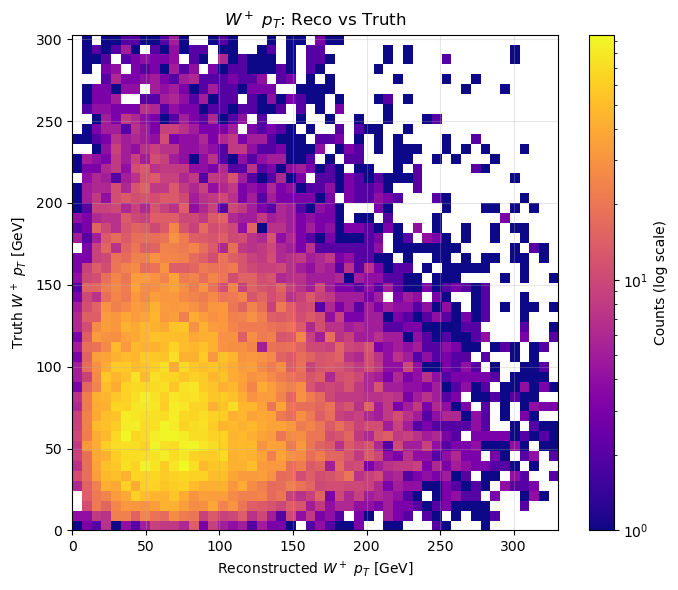

In [53]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# 파일 열기
with h5py.File(path, "r") as f:
    truth_particles = f["delphes/truth_particles"][:]

# W⁺ boson만 선택 (truth)
w_pos_mask = truth_particles["PDGID"] == 24
w_pos_arr_truth = truth_particles[w_pos_mask]
w_truth_pt = w_pos_arr_truth["pt"]

# Reco: lepton + neutrino 로부터 계산된 W⁺ (vector array로 가정)
w_pos_arr_reco = lep_pos_arr + nu_arr
w_reco_pt = w_pos_arr_reco.pt

# 길이 맞추기
min_len = min(len(w_truth_pt), len(w_reco_pt))
w_truth_pt = w_truth_pt[:min_len]
w_reco_pt = w_reco_pt[:min_len]

# 2D 히스토그램 그리기
plt.figure(figsize=(7, 6))
plt.hist2d(
    w_reco_pt,
    w_truth_pt,
    bins=50,
    range=[[0, np.percentile(w_reco_pt, 99)], [0, np.percentile(w_truth_pt, 99)]],
    cmap="plasma",
    norm="log"
)
plt.xlabel("Reconstructed $W^+$ $p_T$ [GeV]")
plt.ylabel("Truth $W^+$ $p_T$ [GeV]")
plt.title("$W^+$ $p_T$: Reco vs Truth")
plt.colorbar(label="Counts (log scale)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [54]:
print("what the fuck")

what the fuck
